In [1]:
from constants import DatasetPath

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import timm

In [2]:
# Main Dataset folder path
DATA_DIR = DatasetPath.effectivePath

# Device to run calculations on 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#CYCLE_GAN and PRO_GAN contains both real and fake images

REAL_DIRS = ["afhq", "celebahq", "coco", "ffhq", "imagenet", "landscape", "lsun", "metfaces", "cycle_gan", "pro_gan"]

FAKE_DIRS = ["big_gan", "cips", "cycle_gan", "ddpm", "denoising_diffusion_gan", "diffusion_gan", "face_synthetics", 
				 "gansformer", "gau_gan", "generative_inpainting", "glide", "lama", "latent_diffusion", "mat", "palette", 
				 "pro_gan", "projected_gan", "sfhq", "stable_diffusion", "star_gan", "stylegan1", "stylegan2", "stylegan3",
				 "taming_transformer", "vq_diffusion"]

In [3]:
def df_to_csv(df, filename, path):
	"""
	Splits the DataFrame in chunks to enable tqdm progress visualization while converting the DataFrame into a '.csv' file.

	Parametres
	----------
		df (pd.DataFrame): the DataFrame to convert.
		filename (str): the desired file name (comprehensive of '.csv' extension).
		path (str): the path where the '.csv' will be stored.
	"""
	chunks = np.array_split(df.index, 100)
	for chunck, subset in enumerate(tqdm(chunks, desc="Creating \'" + filename + "\' file")):
		if chunck == 0: # first row
			df.loc[subset].to_csv(path, mode='w', index=False)
		else:
			df.loc[subset].to_csv(path, header=None, mode='a', index=False)

	print("\'" + filename + "\' has been successfully created.")

In [4]:
df = pd.read_csv(DATA_DIR + "pre_trainingSet.csv")

# MODEL DEFINITION

In [5]:
class APN_Model(nn.Module):
	"""
	Defines a neural network model class APN_Model that uses an EfficientNet (specifically the B0 version) as its backbone.
	"""

	def __init__(self, emb_size = 512):
		"""
		Initializes the APN_Model with a specific model and a classifier that outputs embedding vector of the specified size.

		Parameters
		----------
		emb_size (int, optional): the size of the output embedding vector (default is 512).
		"""
		super(APN_Model, self).__init__()

		# Define the model to use 
		self.efficientnet = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained = True)
		
		# Replace the classifier layer with a linear layer that outputs embeddings of size `emb_size`
		self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

	def forward(self, images):
		"""
		Performs the forward pass of the model, which takes a batch of images and returns their embeddings.

		Parameters
		----------
			images (torch.Tensor): a batch of images to process.

		Returns
		-------
			embeddings (torch.Tensor): a batch of embeddings of size `emb_size`.
		"""
		embeddings = self.efficientnet(images)
		return embeddings

In [ ]:
model = APN_Model()

model.to(DEVICE)

# EMBEDDINGS CALCULATION

In [7]:
def getImageEmbeddings(img_path, model):
	"""
	Generates embeddings for a given image using the provided model.

	Parameters
	----------
		img_path (str): the path to the input image.
		model (torch.nn.Module): the PyTorch model used to generate the image embeddings.

	Returns
	-------
		img_enc (numpy.ndarray): the embeddings of the input image.
	"""
	preprocess = transforms.Compose([
		transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize pixel values to [0, 1]
		transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
	])

	# Read the image from the specified directory
	img = Image.open(DATA_DIR + img_path).convert('RGB')
	# Image preprocessing
	img = preprocess(img).unsqueeze(0)  # Add a batch dimension
	# Move the image tensor to the appropriate device (CPU or GPU)
	img = img.to(DEVICE)
	
	# Set the model to evaluation mode
	model.eval()
	
	# Disable gradient calculation for efficiency
	with torch.no_grad():
		
		# Pass the image through the model to get the embeddings
		img_enc = model(img)
		
		# Detach the embeddings from the computation graph and move them back to the CPU
		img_enc = img_enc.detach().cpu().numpy()

	return img_enc

In [8]:
# Initialize an empty dictionary to store image embeddings
embedding_dict = {}
# Extract unique paths from the 'anchor' column in the DataFrame.
unique_anchor_paths = df['anchor'].unique().tolist()

# Loop through each image path in the 'anchor' column of the DataFrame
for img_path in tqdm(unique_anchor_paths, total=len(unique_anchor_paths), desc="Generating embeddings"):
	# Generate and store the embedding for each anchor image in the dictionary
	embedding_dict[img_path] = getImageEmbeddings(img_path, model)

Generating embeddings:   0%|          | 0/600 [00:00<?, ?it/s]

In [9]:
# Convert the embedding_dict into a DataFrame
# Ensure that each value in the dictionary is a one-dimensional array
embeddings_list = []
for path, emb in embedding_dict.items():
	# Ensure each embedding is a one-dimensional array, for example using numpy flatten
	if isinstance(emb, np.ndarray):
		emb = emb.flatten()
	embeddings_list.append([path] + emb.tolist())

# Create a DataFrame from embeddings_list
embeddings_df = pd.DataFrame(embeddings_list)
columns = ['path'] + [f'embedding_{i}' for i in range(len(embeddings_list[0]) - 1)]
embeddings_df.columns = columns

# Save Embeddings to avoid recalculation on same pre_TrainingSet
df_to_csv(embeddings_df, "mining_embeddings.csv", DATA_DIR + "mining_embeddings.csv")

embeddings_df


Creating 'mining_embeddings.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'mining_embeddings.csv' has been successfully created.


,path,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_502,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511
0,coco/coco/coco2017/test2017/img021550.jpg,0.038088,0.144380,-0.077111,-0.306058,-0.273444,0.254268,0.174461,0.161460,0.031110,...,-0.214668,-0.355985,0.122963,-0.048719,0.502500,0.323285,-0.041415,0.033519,-0.287613,0.032273
1,coco/coco/coco2017/train2017/img070651.jpg,0.000912,-0.159207,-0.354931,0.099113,0.060467,-0.010117,-0.190498,-0.055147,0.004917,...,-0.225201,-0.055478,0.212799,-0.054108,0.092891,-0.032458,-0.125977,0.123489,0.164106,0.160458
2,coco/coco/coco2017/train2017/img078157.jpg,0.051197,-0.009650,0.124447,-0.122352,0.073067,0.078940,-0.073726,-0.070449,-0.017334,...,-0.088484,0.106342,-0.029185,-0.133700,0.061037,0.194077,0.053399,-0.100445,0.022133,-0.012257
3,coco/coco/coco2017/train2017/img141336.jpg,-0.431287,0.261617,-0.118118,0.252708,-0.220574,-0.307171,0.363845,-0.008504,-0.142073,...,-0.039433,-0.152297,-0.003930,-0.444217,0.505701,0.136453,-0.092269,-0.058292,0.006150,0.427491
4,coco/coco/coco2017/train2017/img078071.jpg,-0.361403,0.346828,-0.181751,-0.075242,-0.451084,-0.067862,0.302951,-0.328372,-0.215356,...,-0.176624,0.048856,-0.026227,-0.246421,0.183162,-0.006135,-0.016353,-0.224833,0.015903,0.167465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...,-0.114861,0.049258,-0.164241,0.085121,-0.093709,-0.119633,-0.060077,-0.015669,-0.014570,...,0.056943,0.190837,-0.096438,-0.091608,0.011388,-0.139408,0.129286,0.062338,0.012935,0.116188
596,taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...,0.182652,-0.210487,0.017116,-0.225215,-0.139500,0.289954,-0.020915,-0.059960,0.282660,...,-0.230830,-0.511744,0.193450,-0.363463,0.591447,0.237767,0.013375,-0.032039,0.211410,0.408911
597,taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...,0.043306,0.168394,-0.190155,-0.072914,-0.310828,0.105066,0.023705,-0.125847,0.117197,...,-0.046490,0.096829,-0.059064,-0.173244,0.224766,-0.047602,0.096918,-0.157402,0.064299,0.148780
598,taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...,-0.064867,0.309411,-0.275995,-0.089069,-0.483849,-0.024209,0.089124,-0.221852,0.111386,...,-0.042068,-0.222823,-0.182893,-0.336399,0.270512,0.135474,0.069834,-0.011361,0.013539,0.380713


In [10]:
# Read Embeddings from a saved '.csv' file

embeddings_df = pd.read_csv(DATA_DIR + "mining_embeddings.csv")

embedding_dict = {}
for _, row in embeddings_df.iterrows():
	path = row['path']
	embedding = row[1:].values.astype(np.float32)
	embedding_dict[path] = embedding

# TRIPLETS FILTERING

In [ ]:
# Map the embeddings to the 'anchor_emb' column using the paths from the 'anchor' column
df['anchor_emb'] = df['anchor'].map(embedding_dict)

# Map the embeddings to the 'positive_emb' column using the paths from the 'positive' column
df['positive_emb'] = df['positive'].map(embedding_dict)

# Map the embeddings to the 'negative_emb' column using the paths from the 'negative' column
df['negative_emb'] = df['negative'].map(embedding_dict)

In [ ]:
# Convert numpy arrays to PyTorch tensors
df['anchor_emb'] = [
    torch.tensor(arr) for arr in tqdm(df['anchor_emb'], desc="Converting anchor embeddings to tensors")
]
df['positive_emb'] = [
    torch.tensor(arr) for arr in tqdm(df['positive_emb'], desc="Converting positive embeddings to tensors")
]
df['negative_emb'] = [
    torch.tensor(arr) for arr in tqdm(df['negative_emb'], desc="Converting negative embeddings to tensors")
]

In [12]:
def L2_norm(x, y):
    """
    Calculate the L2 norm (Euclidean distance) between two embeddings.

    Parameters
    ----------
    x : torch.Tensor
        First embedding of shape (embedding_dim,).
    y : torch.Tensor
        Second embedding of shape (embedding_dim,).

    Returns
    -------
    torch.Tensor
        Euclidean distance between x and y.
    """
    return torch.norm(x - y, p=2)

In [ ]:
# Calculate the distances between anchor and positive embeddings
df['dist_anchor_positive'] = [
    L2_norm(row['anchor_emb'], row['positive_emb']).item() 
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating d(a,p)")
]

# Calculate the distances between anchor and negative embeddings
df['dist_anchor_negative'] = [
    L2_norm(row['anchor_emb'], row['negative_emb']).item() 
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating d(a,n)")
]

In [ ]:
margin = 0.2  # Set the margin for semi-hard triplets

# Filter the DataFrame to select semi-hard triplets based on the defined condition
semi_hard_triplets = df[
    (df['dist_anchor_positive'] < df['dist_anchor_negative']) &  # Check if the distance between anchor and positive embeddings is less than the distance between anchor and negative embeddings
    (df['dist_anchor_negative'] < (df['dist_anchor_positive'] + margin))  # Check if the distance between anchor and negative embeddings is less than the distance between anchor and positive embeddings plus the margin
]

# Create a new DataFrame containing only the 'anchor', 'positive', and 'negative' columns from semi_hard_triplets
rgb_train_df = semi_hard_triplets[['anchor', 'positive', 'negative']].copy()

# Visualize Mined Triplets
rgb_train_df

In [ ]:
# Save to '.csv'
df_to_csv(rgb_train_df, "RGB_trainingSet.csv", DATA_DIR + "RGB_trainingSet.csv")

# DATA VISUALIZATION

In [ ]:
triplets_df = pd.read_csv(DATA_DIR + "RGB_trainingSet.csv")

In [23]:
def plot_path_frequency_as_positive(df):
	"""
	Plot the frequency of paths in the 'positive' column of the DataFrame.

	This function calculates the frequency of each unique path in the 'positive'
	column of the provided DataFrame and plots the top 20 most frequent paths
	as a bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing the 'positive' column with paths.
	"""
	
	# Calculate the frequency of 'positive' paths
	positive_counts = df['positive'].value_counts()

	# Create the bar plot
	plt.figure(figsize=(25, 5))
	positive_counts.head(20).plot(kind='bar')
	plt.title('Most Frequent Paths as \'Positive\'')
	plt.xlabel('Path')
	plt.ylabel('Frequency')
	plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
	plt.show()

def plot_path_frequency_as_negative(df):
	"""
	Plot the frequency of paths in the 'negative' column of the DataFrame.

	This function calculates the frequency of each unique path in the 'negative'
	column of the provided DataFrame and plots the top 20 most frequent paths
	as a bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing the 'negative' column with paths.
	"""
	# Calculate the frequency of 'negative' paths
	negative_counts = df['negative'].value_counts()

	# Create the bar plot
	plt.figure(figsize=(25, 5))
	negative_counts.head(20).plot(kind='bar')
	plt.title('Most Frequent Paths as \'Negative\'')
	plt.xlabel('Path')
	plt.ylabel('Frequency')
	plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
	plt.show()

def plot_real_fake_count(df, dataset_partition_path):
	"""
	Plot the count of 'real' and 'fake' images based on the target information from a separate CSV file.

	This function merges the DataFrame containing image paths with another DataFrame that categorizes
	each image as 'real' or 'fake' based on the 'target' column. It then plots these counts as a horizontal bar chart.

	Parameters
	----------
	df (pandas.DataFrame): DataFrame containing 'anchor', 'positive', and 'negative' columns with image paths.
	dataset_partition_path (str): Path to the CSV file containing 'image_path' and 'target' columns.
	"""
	
	# Load the dataset partition DataFrame
	dataset_partition_df = pd.read_csv(dataset_partition_path)
	
	# Merge the anchor paths with the partition DataFrame to get their targets
	df = df.merge(dataset_partition_df, left_on='anchor', right_on='image_path', how='left')

	# Determine the 'Type' based on the 'target' column
	df['Type'] = df['target'].apply(lambda x: 'real' if x == 0 else 'fake')

	# Count occurrences of 'real' and 'fake'
	counts = df['Type'].value_counts()

	# Prepare data for plotting
	counts_df = pd.DataFrame(counts).reset_index()
	counts_df.columns = ['Type', 'Count']

	# Plot horizontal bar chart
	ax = counts_df.plot(kind='barh', x='Type', y='Count', legend=False, color=['blue', 'red'])
	plt.title('Number of images per category in the Training Set')
	plt.xlabel('Count')
	plt.ylabel('Type')

	# Add text annotations to the bars
	for index, value in enumerate(counts_df['Count']):
		ax.text(value, index, str(value), va='center')

	# Expand x-axis to accommodate annotations
	plt.xlim(right=max(counts_df['Count']) * 1.2)

	plt.show()

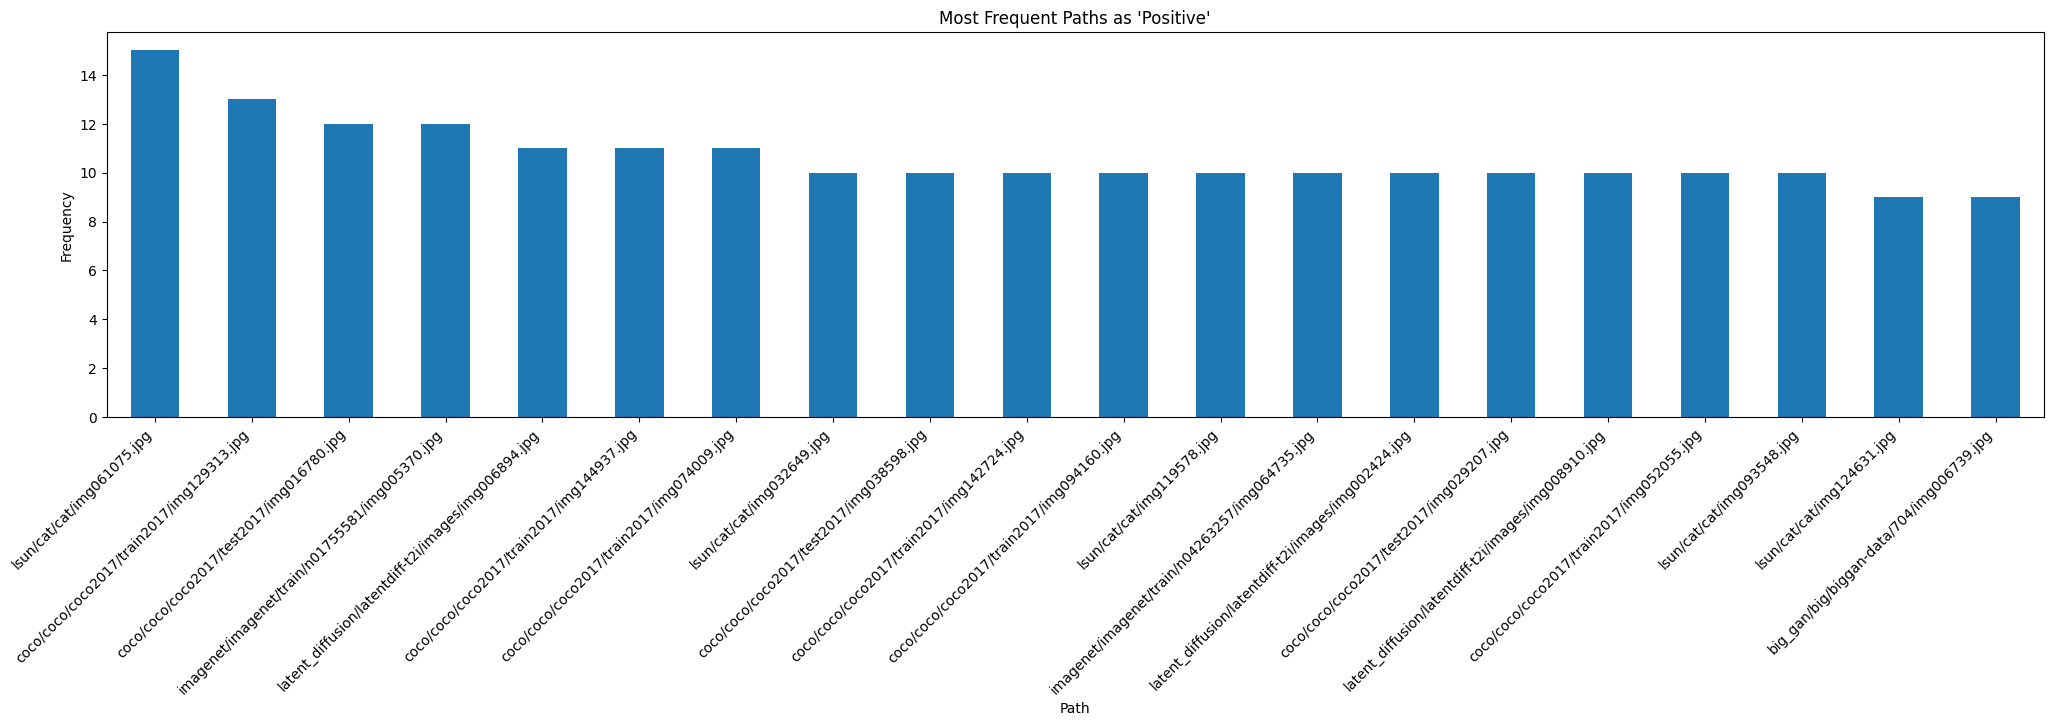

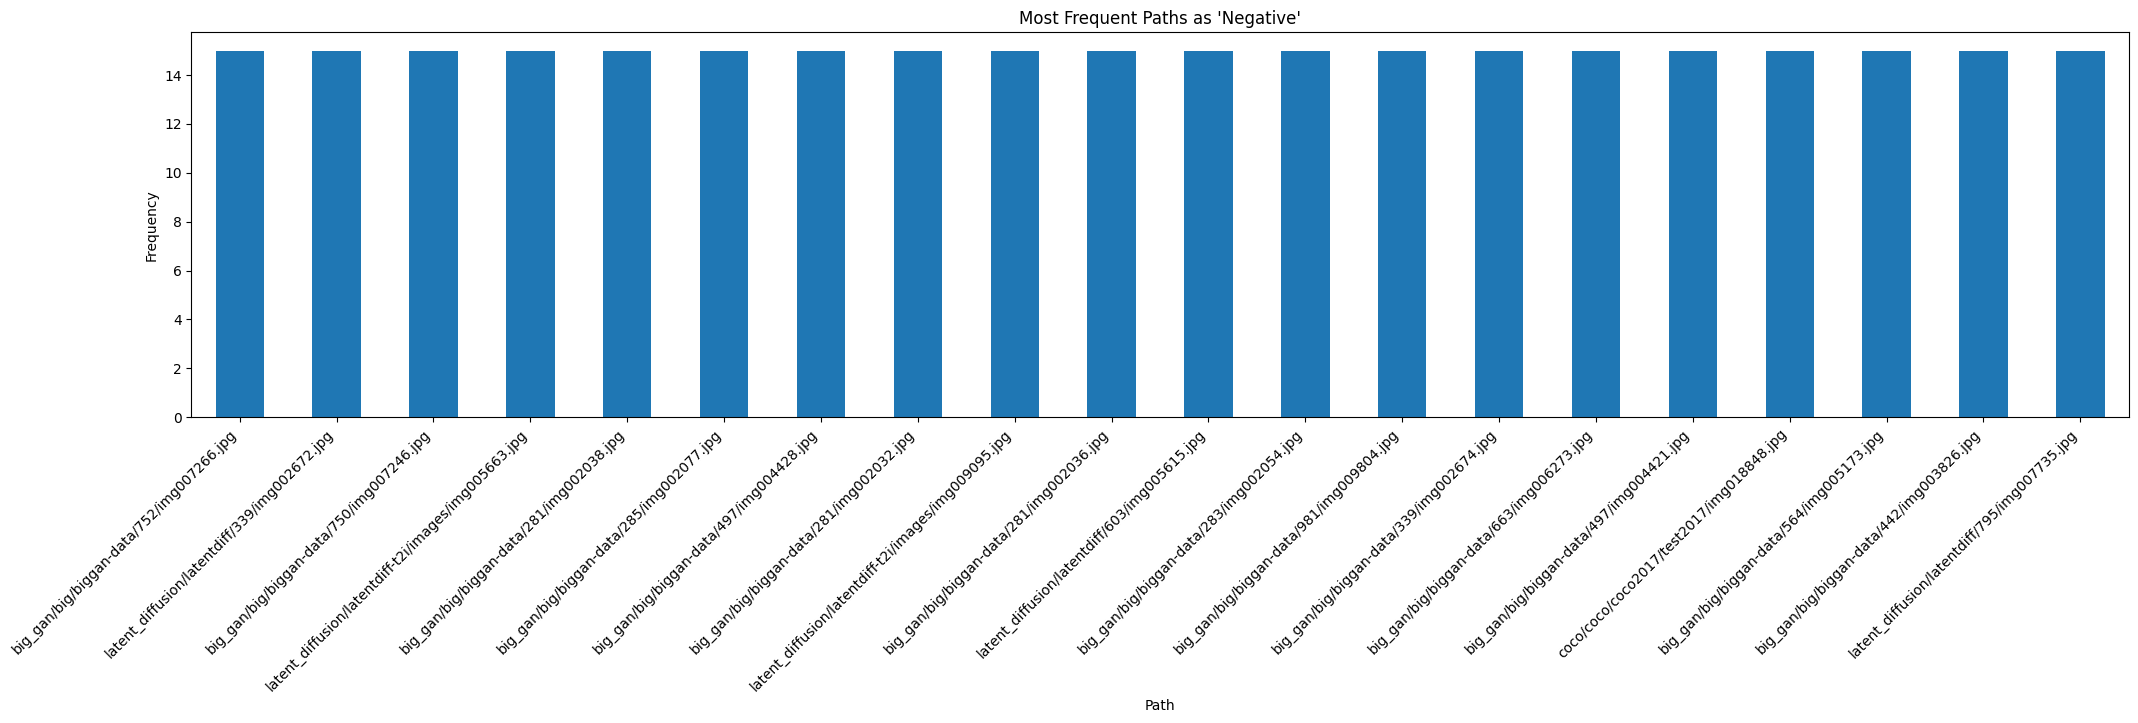

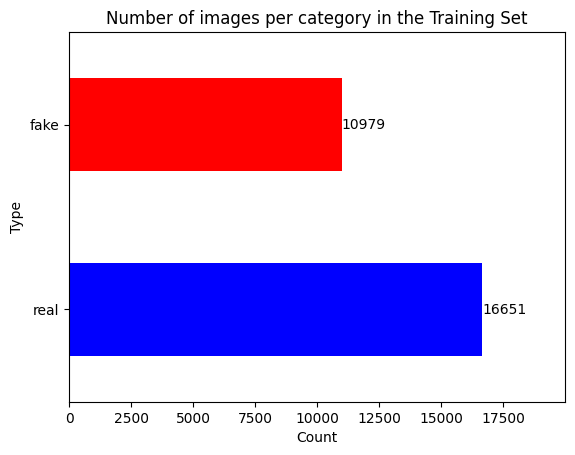

In [24]:
plot_path_frequency_as_positive(triplets_df)
plot_path_frequency_as_negative(triplets_df)
plot_real_fake_count(triplets_df, DATA_DIR + "dataset_partition.csv")

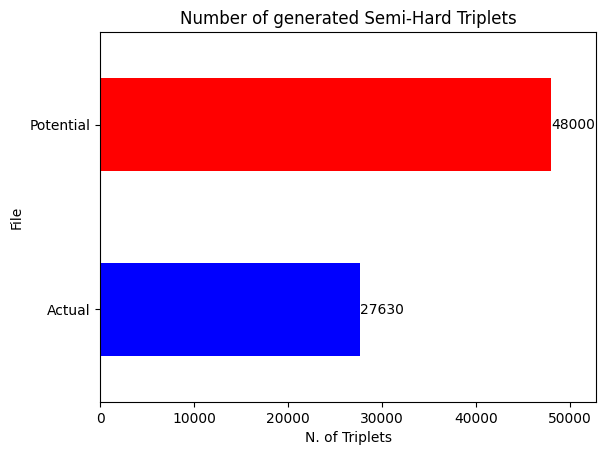

In [25]:
# Read lengths of CSV files
potential_triplets = len(df)
actual_triplets = len(triplets_df)

# Prepare data for plotting
lengths = {'Actual': actual_triplets, 'Potential': potential_triplets}
lengths_df = pd.DataFrame(list(lengths.items()), columns=['File', 'Length'])

# Plot horizontal bar chart
ax = lengths_df.plot(kind='barh', x='File', y='Length', legend=False, color=['blue', 'red'])
plt.title('Number of generated Semi-Hard Triplets')
plt.xlabel('N. of Triplets')
plt.ylabel('File')

# Add text annotations to the bars
for index, value in enumerate(lengths_df['Length']):
	ax.text(value, index, str(value), va='center')

# Expand x-axis to accommodate annotations
plt.xlim(right=max(lengths_df['Length']) * 1.1)

plt.show()

In [26]:
def plot_apn_count_by_source(train_df, apn='anchor'):
	"""
	Plots a bar chart showing the number of 'anchor' images for each source.

	Parameters
	----------
	train_df : pandas.DataFrame
		The dataframe containing the semi-hard mined triplets.
	apn : str (optional)
		'anchor', 'positive' or 'negative', specifies on which member the count should be executed. Default: 'anchor'. 
	"""

	# Count the number of images in each directory
	dir_count = {}
	for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0], desc="Counting images"):
		dir = row[apn].split('/')[0]
		if dir in dir_count:
			dir_count[dir] += 1
		else:
			dir_count[dir] = 1

	# Sort the directories by name
	sorted_dirs = sorted(dir_count.items())

	# Extract the directory names and counts
	dirs, counts = zip(*sorted_dirs)

	# Create the bar chart with different colors
	colors = plt.cm.viridis(np.linspace(0, 1, len(dirs)))  # Use the viridis colormap

	# Create the bar chart
	plt.figure(figsize=(10, 6))
	plt.bar(dirs, counts, color=colors)
	plt.xlabel('Sources')
	plt.ylabel('Number of Images')
	plt.title(f'Number of \'{apn}\' Images per Source')
	plt.xticks(rotation=90)
	plt.show()

Counting images:   0%|          | 0/27630 [00:00<?, ?it/s]

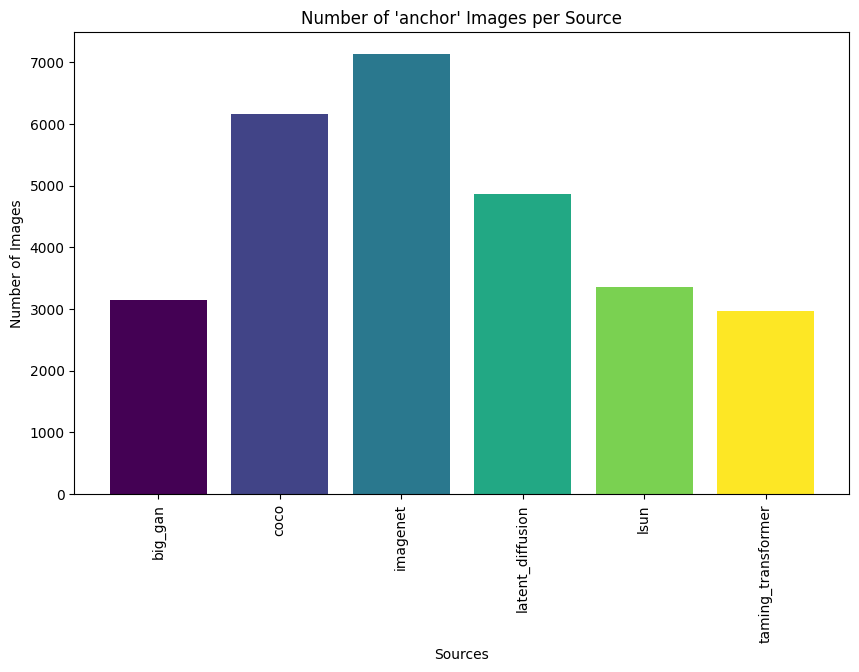

Counting images:   0%|          | 0/27630 [00:00<?, ?it/s]

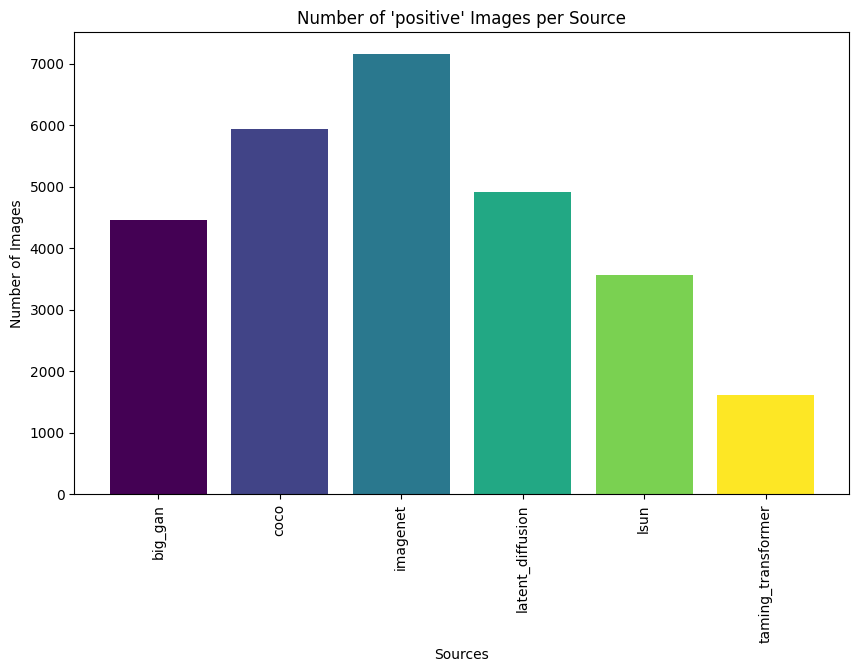

Counting images:   0%|          | 0/27630 [00:00<?, ?it/s]

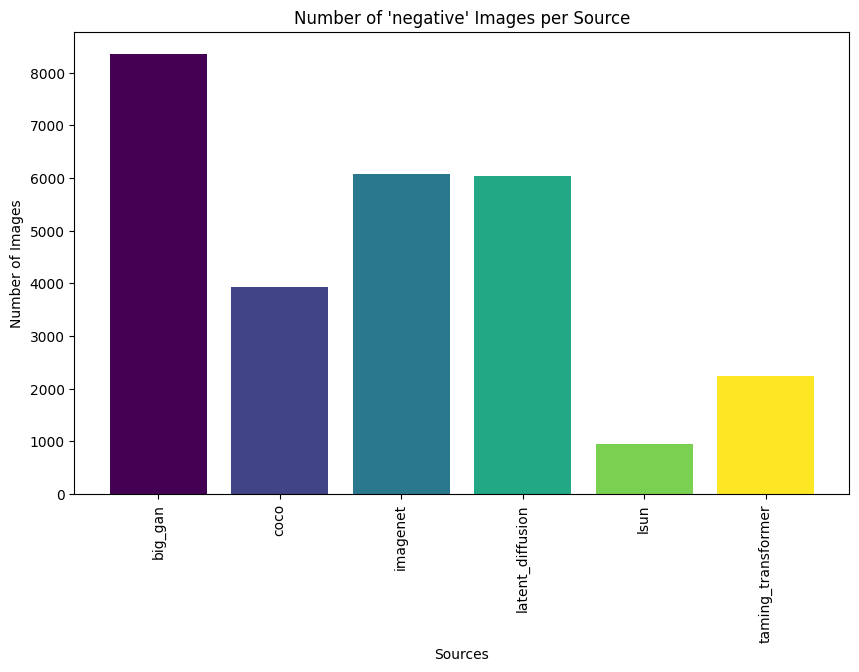

In [27]:
plot_apn_count_by_source(triplets_df)
plot_apn_count_by_source(triplets_df, 'positive')
plot_apn_count_by_source(triplets_df, 'negative')
